In [1]:
import torch
from torch import nn
from Util import d2l
from rgb_anything_v1.dpt import RGBAnything
from cocoloader import cocoloader
import numpy as np
# DINOv2
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\ProgramData\miniconda3\envs\rgb\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'
Using cache found in C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [2]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}


model = RGBAnything(**model_configs['vits'])
model._init_weights()

In [3]:
def get_optimizer(model, lr_base=1e-4, lr_backbone=1e-5, weight_decay=0.001):
    """
    为不同的模块设置不同的学习率
    """
    # 1. 提取 Backbone 参数 (DINOv2)
    backbone_params = model.pretrained.parameters()
    
    # 2. 提取 Head 参数 (DPTHead)
    # 注意：如果你的模型里还有其他随机初始化的层，也应归入此类
    head_params = model.depth_head.parameters()
    
    # 3. 构建参数组
    param_groups = [
        {
            'params': backbone_params, 
            'lr': lr_backbone,       # 预训练部分用小学习率
            'weight_decay': weight_decay
        },
        {
            'params': head_params, 
            'lr': lr_base,           # 随机初始化部分用大学习率
            'weight_decay': weight_decay
        }
    ]
    
    # 4. 初始化优化器 (推荐使用 AdamW，它是 ViT 系列的标准配置)
    optimizer = torch.optim.AdamW(param_groups)
    
    return optimizer

In [4]:
train_iter = cocoloader('data/train_small', batch_size=4)
test_iter = cocoloader('data/test_small', batch_size=4)


loss/10 0.002, train absrel 0.873, test absrel 0.882
14.2 examples/sec on [device(type='cuda', index=0)]


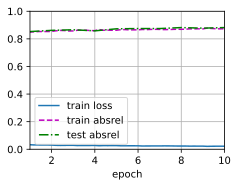

In [ ]:

model.load_state_dict(torch.load('checkpoints/20.pth'))
num_epochs = 40
lr_base = 1e-4
trainer = get_optimizer(model, lr_base=lr_base, lr_backbone=lr_base/10)
epoch = 20
# d2l.train_ch13(model, train_iter, test_iter, nn.MSELoss(), trainer, 10)
# torch.save(model.state_dict(), 'checkpoints/20.pth')


In [ ]:
d2l.train_ch13(model, train_iter, test_iter, nn.MSELoss(), trainer, 10)
torch.save(model.state_dict(), f'checkpoints/30.pth')


In [6]:
import cv2
from matplotlib import pyplot as plt
model.to('cuda')
raw_img = cv2.imread('2025_08_08_02_02_IMG_8783.png')
g_pred = model.infer_image(raw_img)


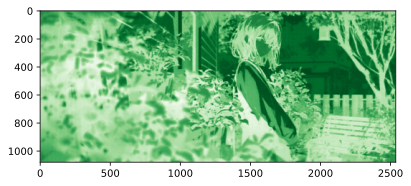

In [7]:
plt.imshow(g_pred, cmap='Greens')

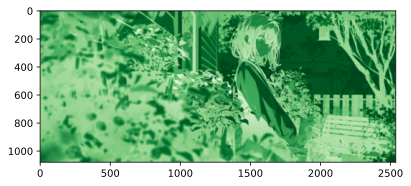

In [8]:
plt.imshow(raw_img[:, :, 1], cmap='Greens')

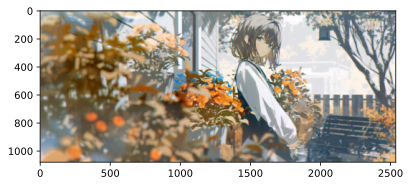

In [9]:
from PIL import Image
pred_img = cv2.cvtColor(np.stack([raw_img[:, :, 0], g_pred, raw_img[:, :, 2]], axis=-1), cv2.COLOR_BGR2RGB)
plt.imshow(pred_img)
Image.fromarray(pred_img).save('synth.png')

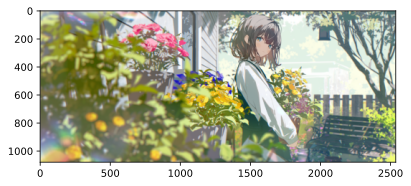

In [10]:
plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))

30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [12]:
# absrel(y_pred, y)